# Using Convolutional Neural Network, Data Augmentation and Transfer Learning to Classify x-ray Images with TensorFlow and Keras

**The goal is to develop an algorithm that can detect pneumonia from chest X-rays at a level exceeding practicing radiologists.**

**14 diseases**
'Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax',
'Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation',
'Infiltration','Fibrosis','Pneumonia'

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

Using TensorFlow backend.


# Import data

In [2]:
path = os.path.abspath(os.path.join('..', '/Users/mmoghimi/Desktop/tdi/Capstone'))
sample_IMG = os.path.join(path,'images' ,'images*')
images = glob(os.path.join(sample_IMG, "*.png"))
#images[1:20]

In [3]:
labels = pd.read_csv('/Users/mmoghimi/Desktop/tdi/Capstone/Data_Entry_2017.csv')
labels.tail(10)

Image Index  Finding Labels  Follow-up #  Patient ID  \
112110  00030797_000.png      No Finding            0       30797   
112111  00030798_000.png      No Finding            0       30798   
112112  00030799_000.png      No Finding            0       30799   
112113  00030800_000.png      No Finding            0       30800   
112114  00030801_000.png      No Finding            0       30801   
112115  00030801_001.png  Mass|Pneumonia            1       30801   
112116  00030802_000.png      No Finding            0       30802   
112117  00030803_000.png      No Finding            0       30803   
112118  00030804_000.png      No Finding            0       30804   
112119  00030805_000.png      No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
112110           24              M            PA                 2021   
112111           30              M            PA                 2500   
112112           32              M            PA                 2048   
112113           34              F            PA                 2048   
112114           39              M            PA                 2500   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x        y]  Unnamed: 11  
112110     2021                     0.194311  0.194311          NaN  
112111     2048                     0.171000  0.171000          NaN  
112112     2500                     0.171000  0.171000          NaN  
112113     2500                     0.168000  0.168000          NaN  
112114     2048                     0.168000  0.168000          NaN  
112115     2500                     0.168000  0.168000          NaN  
112116     2500                     0.168000  0.168000          NaN  
112117     2500                     0.168000  0.168000          NaN  
112118     2500                     0.168000  0.168000          NaN  
112119     2500                     0.171000  0.171000          NaN

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
Image Index                    112120 non-null object
Finding Labels                 112120 non-null object
Follow-up #                    112120 non-null int64
Patient ID                     112120 non-null int64
Patient Age                    112120 non-null int64
Patient Gender                 112120 non-null object
View Position                  112120 non-null object
OriginalImage[Width            112120 non-null int64
Height]                        112120 non-null int64
OriginalImagePixelSpacing[x    112120 non-null float64
y]                             112120 non-null float64
Unnamed: 11                    0 non-null float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


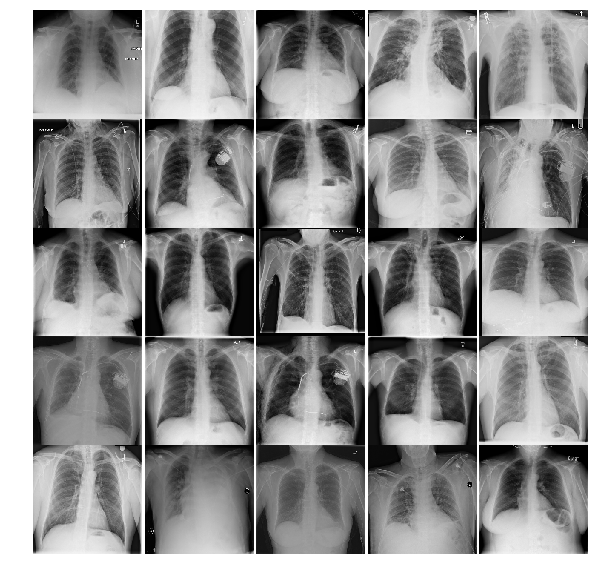

In [5]:
multipleImages = glob('/Users/mmoghimi/Desktop/tdi/Capstone/images*/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (256, 256)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

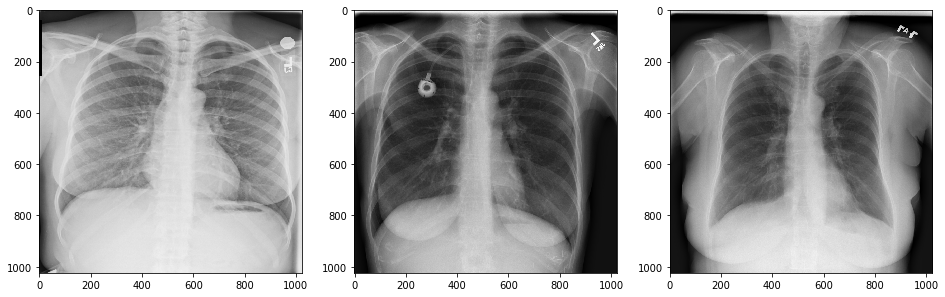

In [6]:
r = random.sample(images, 3)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))
plt.subplot(132)
plt.imshow(cv2.imread(r[1]))
plt.subplot(133)
plt.imshow(cv2.imread(r[2])); 

In [7]:
#labels = pd.read_csv('/Users/mmoghimi/Desktop/tdi/Capstone/images/sample/sample_labels.csv')
print(len(labels))
labels.head(-5)

112120


Image Index                                Finding Labels  \
0       00000001_000.png                                  Cardiomegaly   
1       00000001_001.png                        Cardiomegaly|Emphysema   
2       00000001_002.png                         Cardiomegaly|Effusion   
3       00000002_000.png                                    No Finding   
4       00000003_000.png                                        Hernia   
5       00000003_001.png                                        Hernia   
6       00000003_002.png                                        Hernia   
7       00000003_003.png                           Hernia|Infiltration   
8       00000003_004.png                                        Hernia   
9       00000003_005.png                                        Hernia   
10      00000003_006.png                                        Hernia   
11      00000003_007.png                                        Hernia   
12      00000004_000.png                                   Mass|Nodule   
13      00000005_000.png                                    No Finding   
14      00000005_001.png                                    No Finding   
15      00000005_002.png                                    No Finding   
16      00000005_003.png                                    No Finding   
17      00000005_004.png                                    No Finding   
18      00000005_005.png                                    No Finding   
19      00000005_006.png                                  Infiltration   
20      00000005_007.png                         Effusion|Infiltration   
21      00000006_000.png                                    No Finding   
22      00000007_000.png                                    No Finding   
23      00000008_000.png                                  Cardiomegaly   
24      00000008_001.png                                    No Finding   
25      00000008_002.png                                        Nodule   
26      00000009_000.png                                     Emphysema   
27      00000010_000.png                                  Infiltration   
28      00000011_000.png                                      Effusion   
29      00000011_001.png                                    No Finding   
...                  ...                                           ...   
112085  00030781_000.png                                    No Finding   
112086  00030782_000.png                                    No Finding   
112087  00030783_000.png                                    No Finding   
112088  00030784_000.png                                    No Finding   
112089  00030785_000.png                                    No Finding   
112090  00030786_000.png                                      Effusion   
112091  00030786_001.png               Effusion|Emphysema|Pneumothorax   
112092  00030786_002.png  Cardiomegaly|Effusion|Emphysema|Pneumothorax   
112093  00030786_003.png  Cardiomegaly|Effusion|Emphysema|Pneumothorax   
112094  00030786_004.png  Cardiomegaly|Effusion|Emphysema|Pneumothorax   
112095  00030786_005.png               Cardiomegaly|Effusion|Emphysema   
112096  00030786_006.png                                 Consolidation   
112097  00030786_007.png              Consolidation|Pleural_Thickening   
112098  00030787_000.png                                    No Finding   
112099  00030788_000.png                                    No Finding   
112100  00030789_000.png                                  Infiltration   
112101  00030790_000.png                                    No Finding   
112102  00030791_000.png                                    No Finding   
112103  00030791_001.png                                    No Finding   
112104  00030792_000.png                                    No Finding   
112105  00030792_001.png                                    No Finding   
112106  00030793_000.png                                   Mass|Nodule   
112107  00030794_

In [8]:
#drop unused columns
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
#labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)
labels.head(5)

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender  Cardiomegaly  Emphysema  Effusion  Hernia  \
0           58              M             1          0         0       0   
1           58              M             1          1         0       0   
2           58              M             1          0         1       0   
3           81              M             0          0         0       0   
4           81              F             0          0         0       1   

   Nodule  Pneumothorax  Atelectasis  Pleural_Thickening  Mass  Edema  \
0       0             0            0                   0     0      0   
1       0             0            0                   0     0      0   
2       0             0            0                   0     0      0   
3       0             0            0                   0     0      0   
4       0             0            0                   0     0      0   

   Consolidation  Infiltration  Fibrosis  Pneumonia  
0              0             0         0          0  
1              0             0         0          0  
2              0             0         0          0  
3              0             0         0          0  
4              0             0         0          0

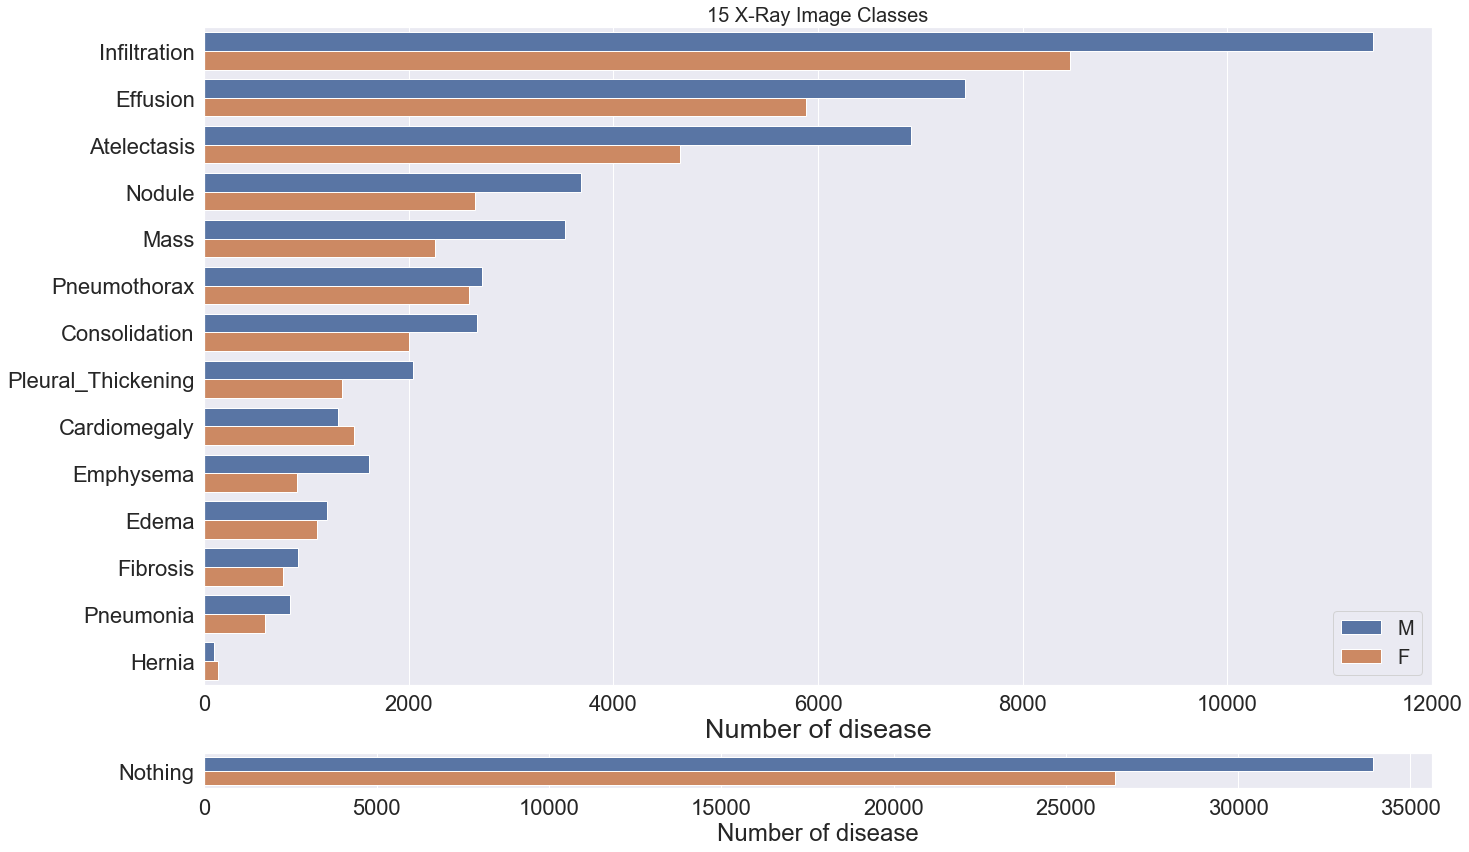

In [9]:
plt.figure(figsize=(22,14))
sns.set(font_scale=2.0)
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('15 X-Ray Image Classes',fontsize=20);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of disease")
ax1.set_ylabel("",fontsize=27)
ax1.set_xlabel("Number of disease",fontsize=27)
plt.subplots_adjust(hspace=1.95)

ax2.legend('', frameon=False)
#svm = sn.heatmap(df_cm, annot=True,cmap='coolwarm', linecolor='white', linewidths=1)
figure = g.get_figure()    
figure.savefig('15Classes.png', dpi=400)


/Users/mmoghimi/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/mmoghimi/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


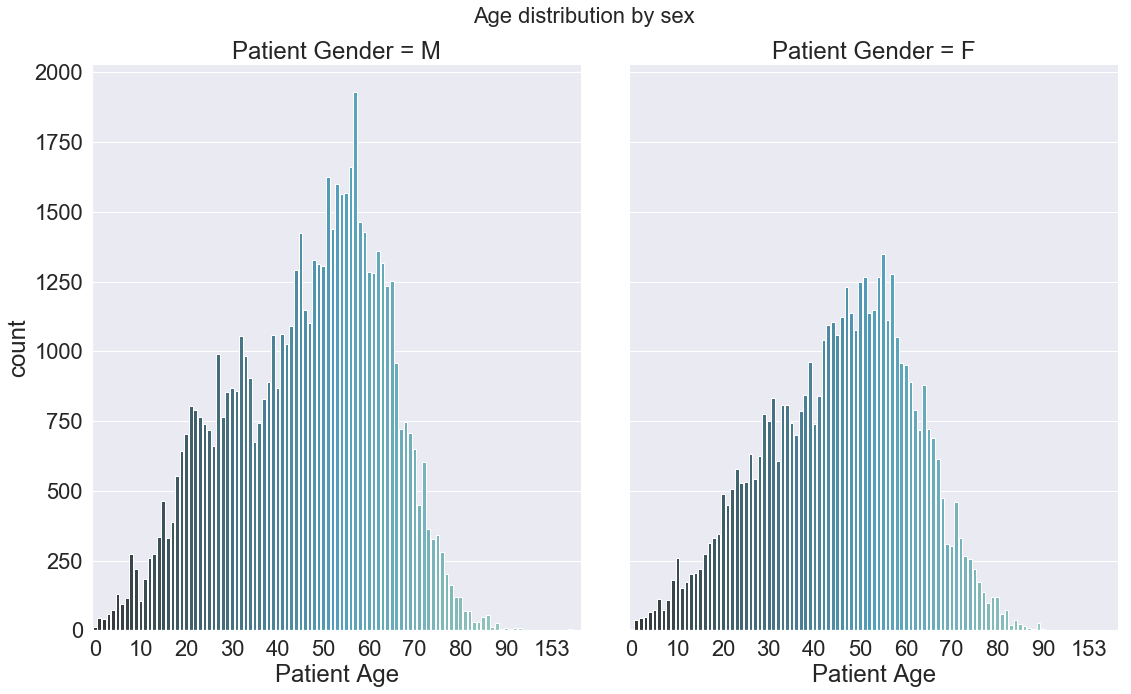

In [10]:
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=labels, kind="count",size=10, aspect=0.8,palette="GnBu_d");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex',fontsize=22);
g.fig.subplots_adjust(top=.9)
#figure = g.get_figure()    
g.savefig('Age_dist_Gen.png', dpi=400)

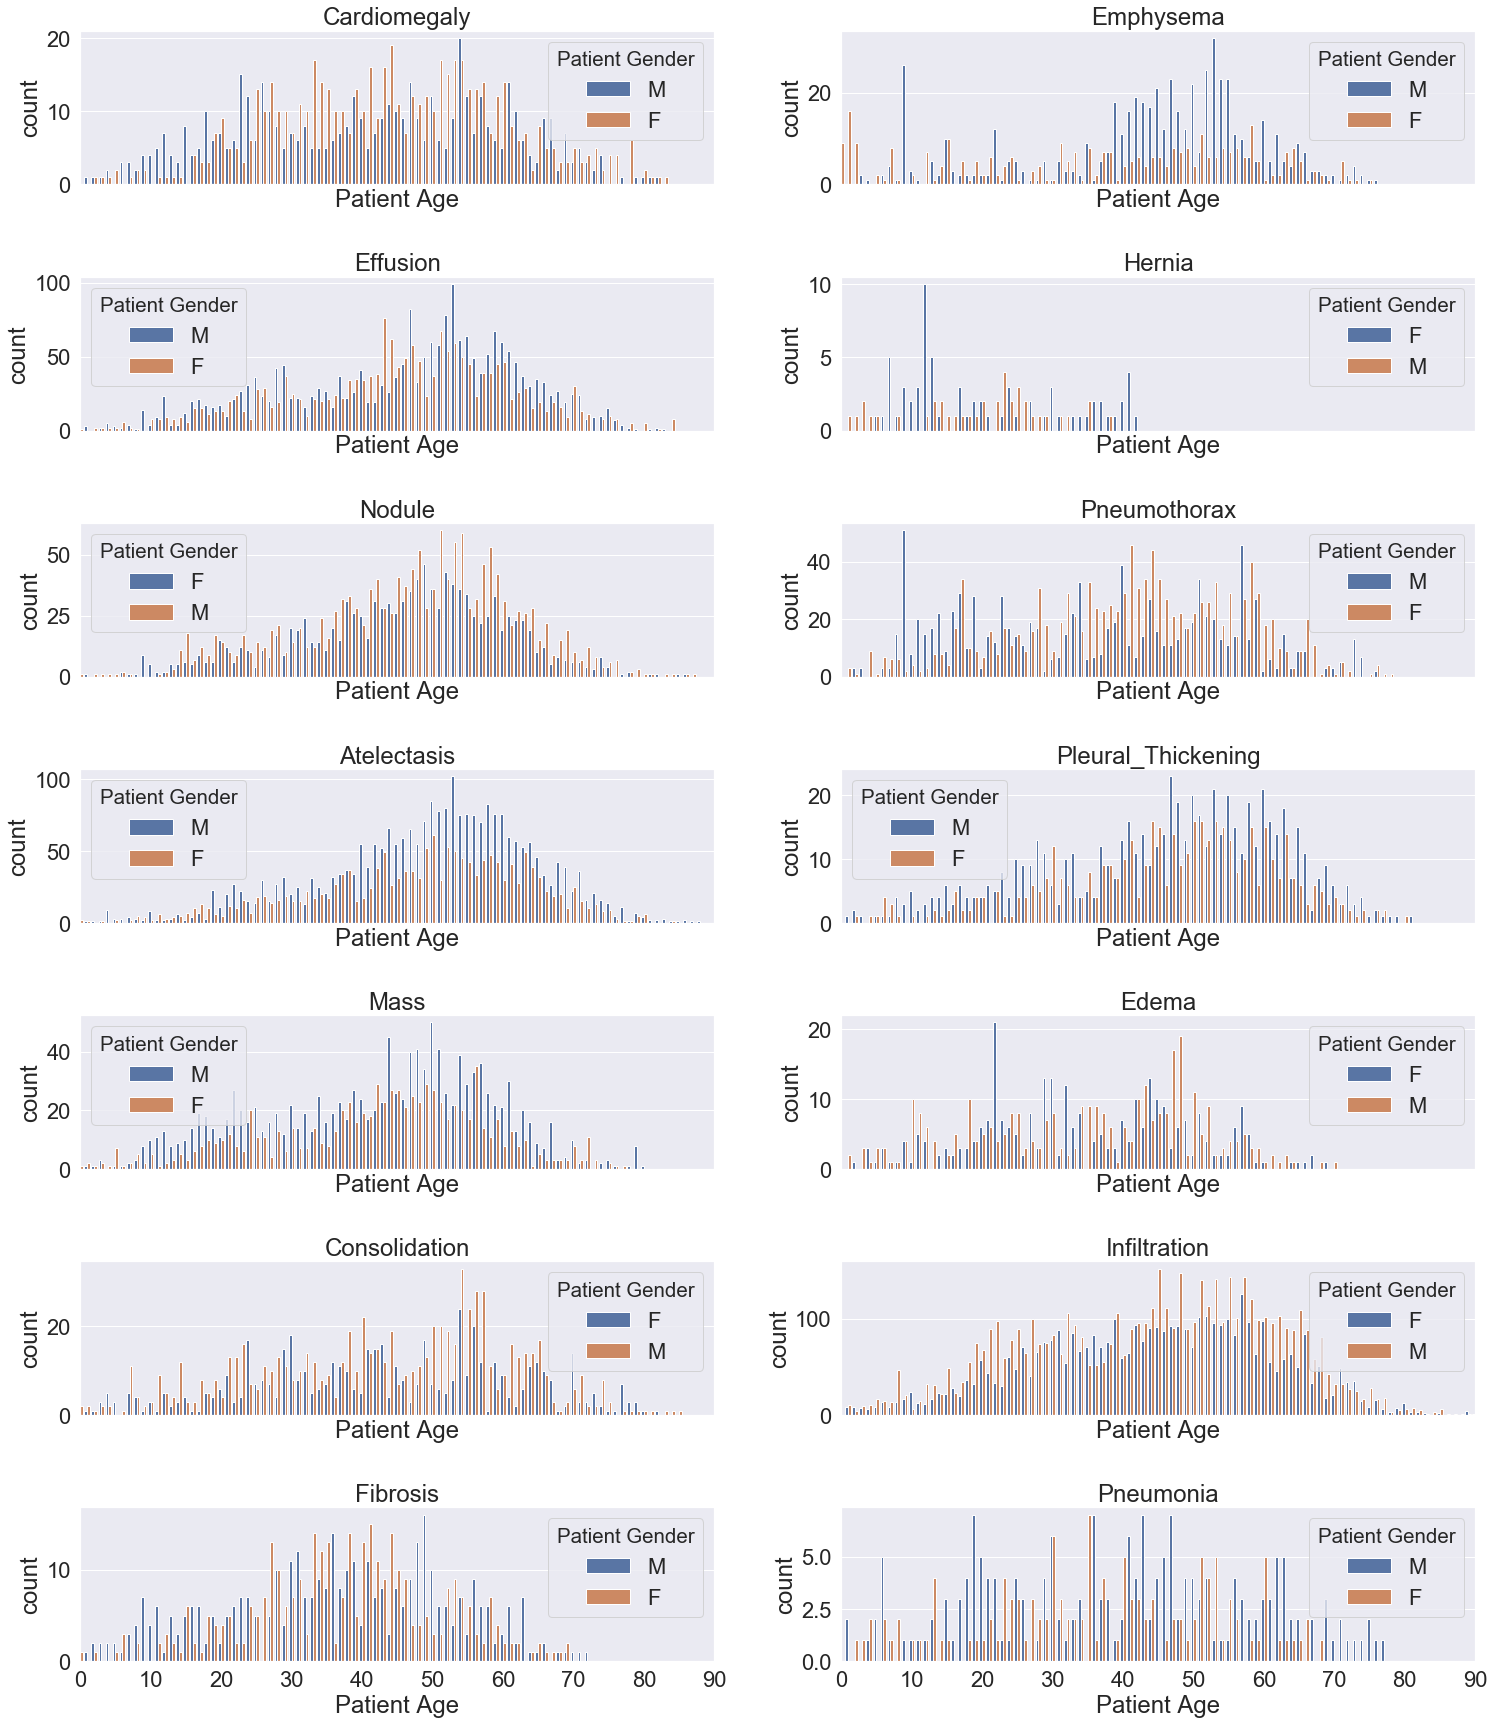

In [11]:
df=labels
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(25, 30))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df[df['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.6)

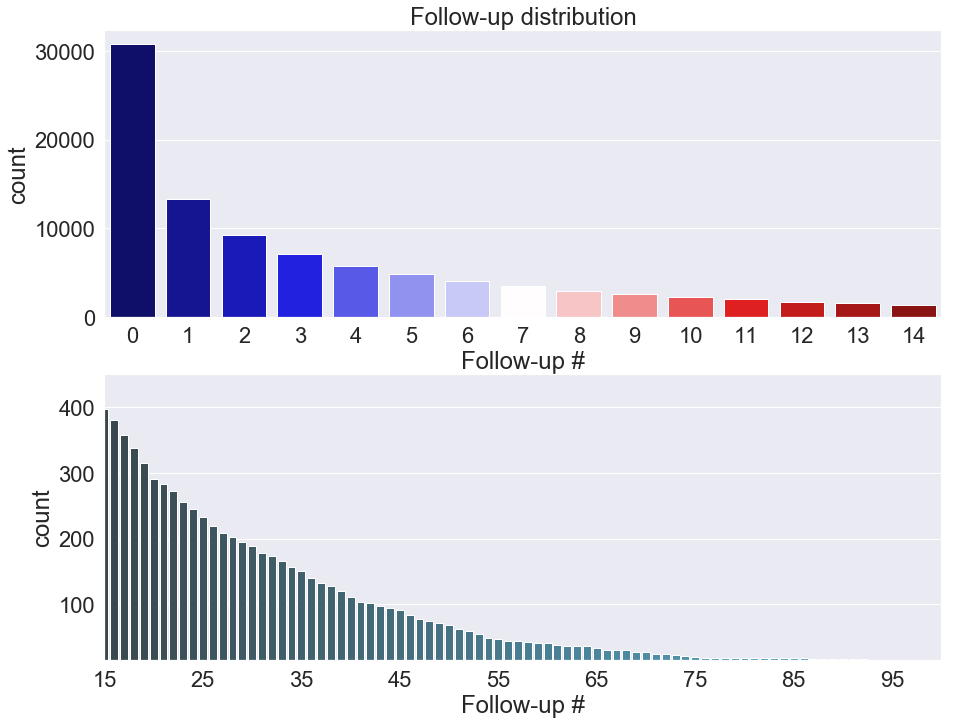

In [13]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

data = df[df['Follow-up #']<15]
g = sns.countplot(x='Follow-up #',data=data,palette="seismic",ax=ax1);

ax1.set_title('Follow-up distribution');
data = df[df['Follow-up #']>14]
g = sns.countplot(x='Follow-up #',data=data,palette="GnBu_d",ax=ax2);
x=np.arange(15,100,10)
g.set_ylim(15,450)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(top=1)

In [14]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

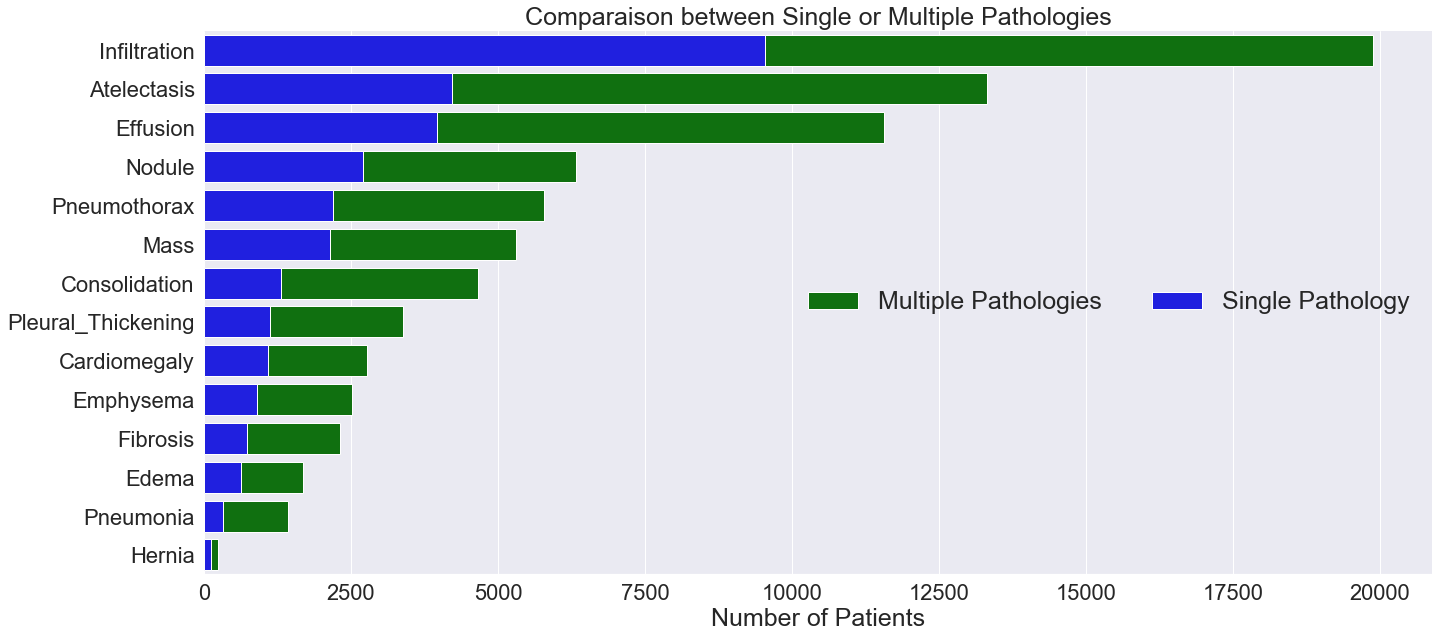

In [15]:
f, ax = plt.subplots(sharex=True,figsize=(22, 10))
sns.set(font_scale=2.0)
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='green',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="blue",label="Single Pathology")
ax.legend(ncol=2, loc="center right", frameon=False,fontsize=25)
ax.set_xlabel("Number of Patients",fontsize=25)
ax.set_ylabel("",fontsize=20)
#ax.set( ylabel="",xlabel="Number of Patients")
ax.set_title("Comparaison between Single or Multiple Pathologies",fontsize=25)      
sns.despine(left=True)
figure = g.get_figure()    
figure.savefig('Single_Multiple Pathologies.png', dpi=400)

In [16]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)
df3.head(5)

Patient ID  \
Finding Labels                                  
Effusion|Infiltration                    1603   
Atelectasis|Infiltration                 1350   
Atelectasis|Effusion                     1165   
Infiltration|Nodule                       829   
Atelectasis|Effusion|Infiltration         737   

                                                      Finding Labels  \
Finding Labels                                                         
Effusion|Infiltration                          Effusion|Infiltration   
Atelectasis|Infiltration                    Atelectasis|Infiltration   
Atelectasis|Effusion                            Atelectasis|Effusion   
Infiltration|Nodule                              Infiltration|Nodule   
Atelectasis|Effusion|Infiltration  Atelectasis|Effusion|Infiltration   

                                   Cardiomegaly  Emphysema  Effusion  Hernia  \
Finding Labels                                                                 
Effusion|Infiltration                         0          0      1603       0   
Atelectasis|Infiltration                      0          0         0       0   
Atelectasis|Effusion                          0          0      1165       0   
Infiltration|Nodule                           0          0         0       0   
Atelectasis|Effusion|Infiltration             0          0       737       0   

                                   Nodule  Pneumothorax  Atelectasis  \
Finding Labels                                                         
Effusion|Infiltration                   0             0            0   
Atelectasis|Infiltration                0             0         1350   
Atelectasis|Effusion                    0             0         1165   
Infiltration|Nodule                   829             0            0   
Atelectasis|Effusion|Infiltration       0             0          737   

                                   Pleural_Thickening  Mass  Edema  \
Finding Labels                                                       
Effusion|Infiltration                               0     0      0   
Atelectasis|Infiltration                            0     0      0   
Atelectasis|Effusion                                0     0      0   
Infiltration|Nodule                                 0     0      0   
Atelectasis|Effusion|Infiltration                   0     0      0   

                                   Consolidation  Infiltration  Fibrosis  \
Finding Labels                                                             
Effusion|Infiltration                          0          1603         0   
Atelectasis|Infiltration                       0          1350         0   
Atelectasis|Effusion                           0             0         0   
Infiltration|Nodule                            0           829         0   
Atelectasis|Effusion|Infiltration              0           737         0   

                                   Pneumonia  
Finding Labels                                
Effusion|Infiltration                      0  
Atelectasis|Infiltration                   0  
Atelectasis|Effusion                       0  
Infiltration|Nodule                        0  
Atelectasis|Effusion|Infiltration          0

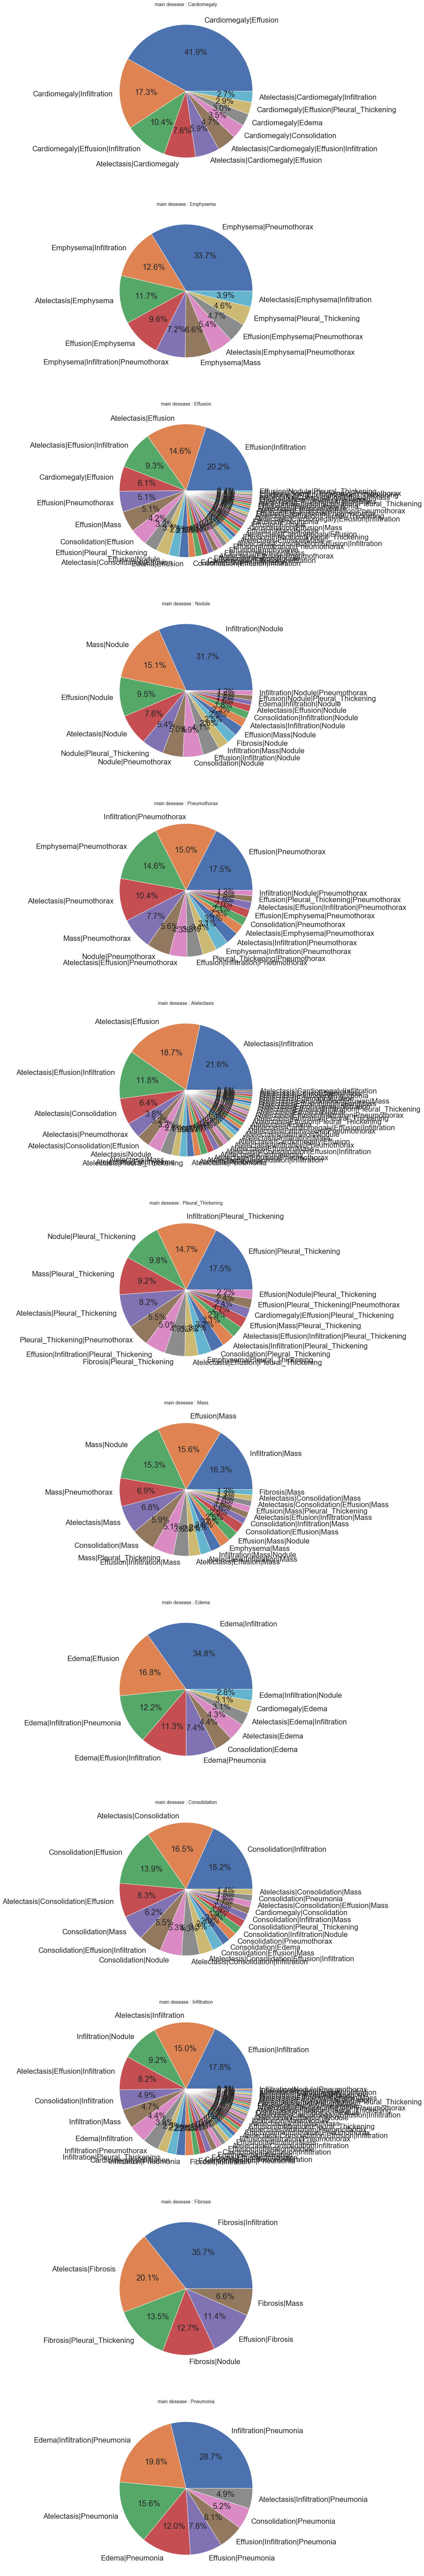

In [17]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1

# Process the images-convert them to numpy array

In [18]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]

In [21]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 7
    Emphysema="Emphysema" #7
    Fibrosis="Fibrosis" #7
    Effusion="Effusion" #4
    Pneumonia="Pneumonia" #7
    Pleural_Thickening="Pleural_Thickening" #7
    Cardiomegaly="Cardiomegaly" #7
    NoduleMass="Nodule" #5
    Hernia="Hernia" #7
    Atelectasis="Atelectasis"  #6 
    RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 128
    HEIGHT = 128
    for img in images:
        base = os.path.basename(img)
        # Read and resize image
        full_size_image = cv2.imread(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        symbol = "|"
        if symbol in finding:
            continue
        else:
            if NoFinding in finding:
                finding = 0
                #y.append(finding)
                #x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Consolidation in finding:
                finding = 1
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Infiltration in finding:
                finding = 2
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumothorax in finding:
                finding = 3
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Edema in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Emphysema in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Fibrosis in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Effusion in finding:
                finding = 4
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumonia in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pleural_Thickening in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Cardiomegaly in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif NoduleMass in finding:
                finding = 5
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Hernia in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Atelectasis in finding:
                finding = 6
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            else:
                continue
    return x,y

In [19]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(type(X))

30737 (128, 128, 3)
<class 'list'>


In [109]:
len(df[:1000])

1000

In [20]:
Xa=np.asarray(X)
ya=np.asarray(y)
np.save('Xa', Xa)
np.save('ya', ya)
#Xa = np.load('Xa.npy')
#ya = np.load('ya.npy')

In [21]:
X=Xa/225.0
np.save('XaN', X)

In [22]:
np.shape(X)

(30737, 128, 128, 3)

In [105]:
Xs5=X[::5]
Ys5=ya[::5]
np.shape(Xs5)

(1230, 128, 128, 3)

In [107]:
np.shape(X[:100])

(100, 128, 128, 3)

In [27]:
np.save('Xs5', Xs5)
np.save('Ys5', Ys5)

In [28]:
X=Xs5
y=Ys5

In [29]:
dict_characters = {1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4:'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: "Other Rare Classes"}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[95, 95, 95], [53, 53, 53], [29, 29, 29], [1...       6
1  [[[11, 11, 11], [0, 0, 0], [0, 0, 0], [0, 0, 0...       2
2  [[[0, 0, 0], [0, 0, 0], [14, 14, 14], [6, 6, 6...       2
3  [[[7, 7, 7], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       6
4  [[[12, 12, 12], [11, 11, 11], [12, 12, 12], [1...       5
5  [[[0, 0, 0], [23, 23, 23], [16, 16, 16], [10, ...       2
6  [[[7, 7, 7], [9, 9, 9], [11, 11, 11], [12, 12,...       2
7  [[[46, 46, 46], [17, 17, 17], [0, 0, 0], [0, 0...       2
8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       2
9  [[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], ...       4

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


W0727 14:04:44.048472 4772812224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


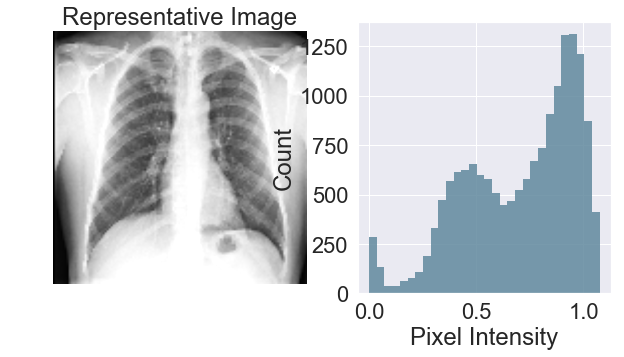

In [30]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X[1])

W0727 14:04:52.697087 4772812224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


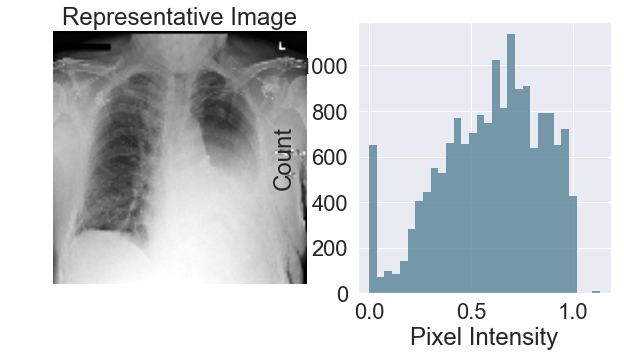

In [31]:
#X=np.array(X)
#X=Xa/255.0
plotHistogram(X[4])

**Distribution of class labels**

In [33]:
#df['labels']

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


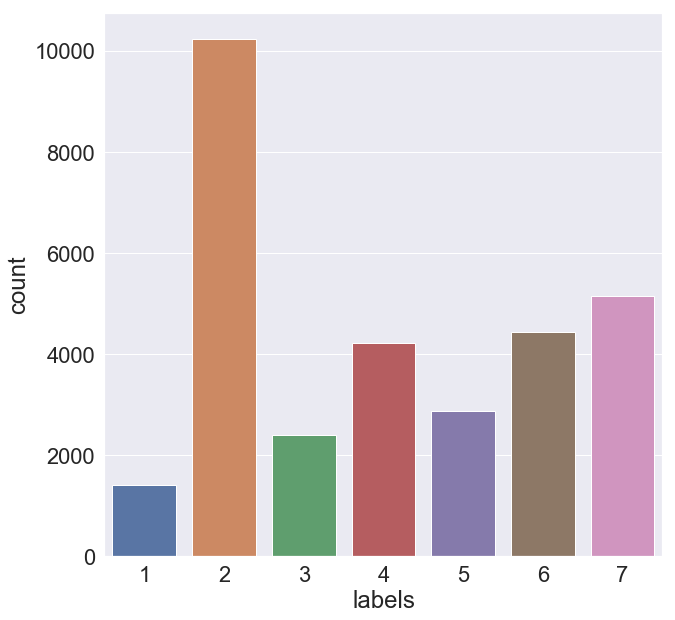

In [34]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
#print(dist)

**We have imbalanced sample sizes. This is a problem that needs to be addressed. But for now we can proceed with a preliminary analysis.**

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (4918, 128, 128, 3)
Testing Data Shape: (1230, 128, 128, 3)
Training Data Shape: 4918 (128, 128, 3)
Testing Data Shape: 1230 (128, 128, 3)


In [49]:
"""X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_traind = X_train[0:5000] 
Y_traind = Y_train[0:5000]
X_testd = X_test[0:2000] 
Y_testd = Y_test[0:2000]"""

In [50]:
"""print("Training Data Shape:", X_traind.shape)
print("Testing Data Shape:", X_testd.shape)
print("Training Data Shape:", len(X_traind), X_traind[0].shape)
print("Testing Data Shape:", len(X_testd), X_testd[0].shape)"""

Training Data Shape: (1186, 128, 128, 3)
Testing Data Shape: (297, 128, 128, 3)
Training Data Shape: 1186 (128, 128, 3)
Testing Data Shape: 297 (128, 128, 3)


**Using a CNN to predict each ailment based off of the X-Ray image.**

In [36]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 8)
Y_testHot = to_categorical(Y_test, num_classes = 8)

**In order to avoid having a biased model because of skewed class sizes, I will modify the class_weights parameter in order to give more weight to the rare classes. In this case the class_weights parameter will eventually be passed to the model.fit function.**

In [37]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[3.43080357 0.42429262 1.86472551 1.09511934 1.39410431 0.99918739
 0.84450549]


In [90]:
# Helper Functions  Learning Curves and Confusion Matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [86]:
"""X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]"""

'X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)\n# Reduce Sample Size for DeBugging\nX_train = X_train[0:5000] \nY_train = Y_train[0:5000]\nX_test = X_test[0:2000] \nY_test = Y_test[0:2000]'

In [39]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

X_train Shape:  (4918, 128, 128, 3)
X_test Shape:  (1230, 128, 128, 3)
X_trainFlat Shape:  (4918, 49152)
X_testFlat Shape:  (1230, 49152)


In [40]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 8)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 8)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
print("Y_testRosHot Shape: ",Y_testRosHot.shape)

X_train:  (4918, 128, 128, 3)
X_trainFlat:  (4918, 49152)
X_trainRos Shape:  (11683, 49152)
X_testRos Shape:  (2807, 49152)
Y_trainRosHot Shape:  (11683, 8)
Y_testRosHot Shape:  (2807, 8)


In [41]:
for i in range(len(X_trainRos)):
    height, width, channels = 128,128,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 128,128,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

X_trainRos Shape:  (11683, 49152)
X_trainRosReshaped Shape:  (11683, 128, 128, 3)
X_testRos Shape:  (2807, 49152)
X_testRosReshaped Shape:  (2807, 128, 128, 3)


{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


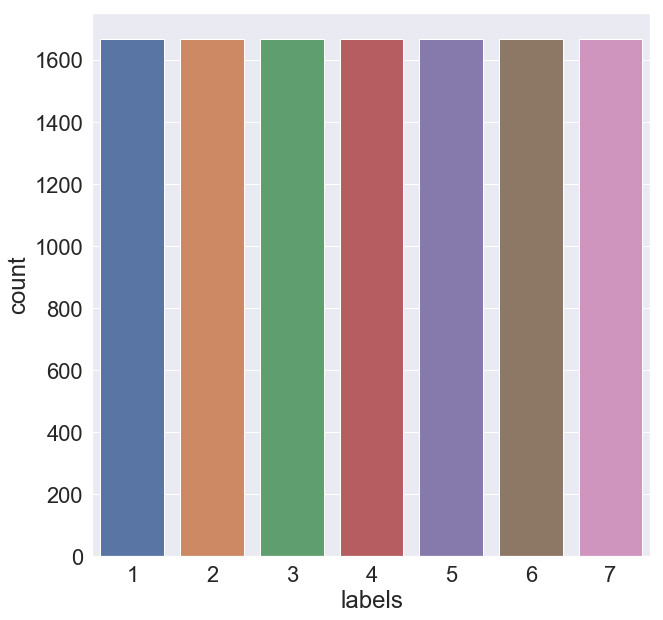

In [42]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [61]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Old Class Weights:  [3.43080357 0.42429262 1.86472551 1.09511934 1.39410431 0.99918739
 0.84450549]
New Class Weights:  [1. 1. 1. 1. 1. 1. 1.]


In [63]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_path ='/Users/mmoghimi/Desktop/tdi/Capstone/images/sample/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
im_size = 128
map_characters=dict_characters

In [73]:
def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(#weights='imagenet',
        weights = weight_path, include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    history=model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    model.save('my_model.h5')
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
#vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,5)

In [74]:
map_characters={1: 'Consolidation',
 2: 'Infiltration',
 3: 'Pneumothorax',
 4: 'Effusion',
 5: 'Nodule Mass',
 6: 'Atelectasis',
 7: 'Other Rare Classes'}

In [75]:
list(map_characters.values())

['Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Effusion',
 'Nodule Mass',
 'Atelectasis',
 'Other Rare Classes']

In [84]:
num_class = 8 # f
epochs = 3# g
base_model = VGG16(weights = weight_path, include_top=False, input_shape=(im_size, im_size, 3))

In [85]:
# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_class, activation='softmax')(x)

In [87]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [88]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])

In [91]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()
history=model.fit(X_trainRosReshaped, Y_trainRosHot, epochs=2,
                  class_weight=class_weight,
                  validation_data=(X_testRosReshaped, Y_testRosHot),
                  verbose=1,callbacks = [MetricsCheckpoint('logs')])

model.save('my_model2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [93]:
history.history['acc']

[0.41487631601727315, 0.43790122400323567]

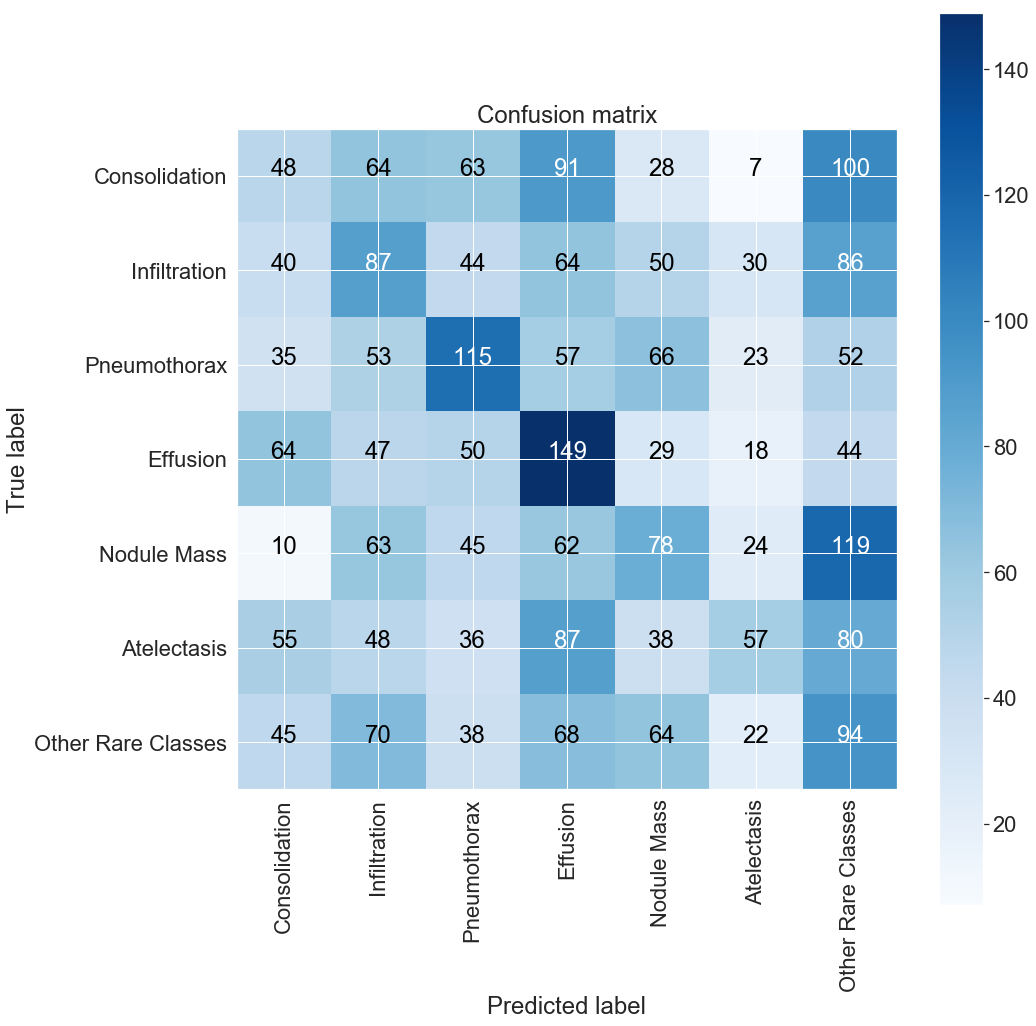

In [66]:
y_pred = model.predict(X_testRosReshaped)
Y_pred_classes = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(Y_testRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.savefig("confusion.png", dpi=450 )
plt.show()

# Binary Classification 

In [22]:
# Data for 5k images
X = np.load('/Users/mmoghimi/Desktop/tdi/Capstone/5k/X5k.npy')
y = np.load('/Users/mmoghimi/Desktop/tdi/Capstone/5k/y5k.npy')
df = pd.read_pickle("/Users/mmoghimi/Desktop/tdi/Capstone/5k/df5k.pkl")

In [23]:
dict_characters = {0: 'Normal', 1: 'Abnormal'}

{0: 'Normal', 1: 'Abnormal'}
0    3550
1    1450
Name: labels, dtype: int64


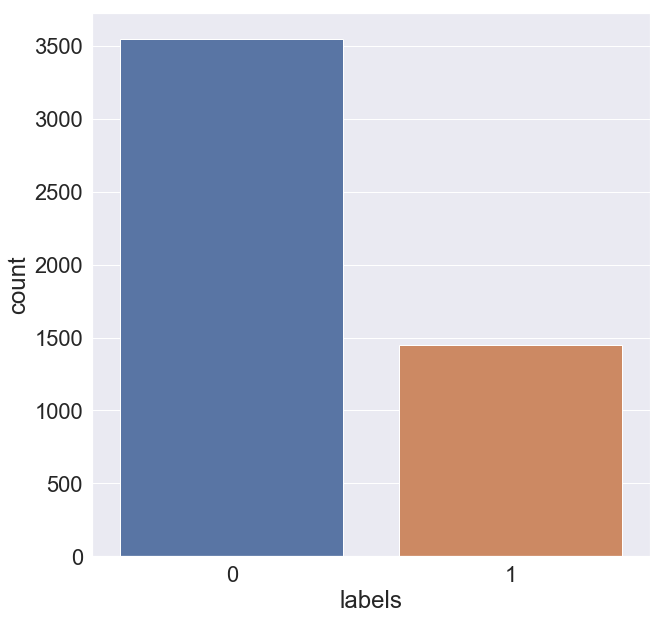

In [24]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
print(dist)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (4000, 128, 128, 3)
Testing Data Shape: (1000, 128, 128, 3)
Training Data Shape: 4000 (128, 128, 3)
Testing Data Shape: 1000 (128, 128, 3)


In [26]:
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

In [27]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[0.70422535 1.72413793]


In [28]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

X_train Shape:  (4000, 128, 128, 3)
X_test Shape:  (1000, 128, 128, 3)
X_trainFlat Shape:  (4000, 49152)
X_testFlat Shape:  (1000, 49152)


In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
print("Y_testRosHot Shape: ",Y_testRosHot.shape)

X_train:  (4000, 128, 128, 3)
X_trainFlat:  (4000, 49152)
X_trainRos Shape:  (5644, 49152)
X_testRos Shape:  (1456, 49152)
Y_trainRosHot Shape:  (5644, 2)
Y_testRosHot Shape:  (1456, 2)


In [30]:
for i in range(len(X_trainRos)):
    height, width, channels = 128,128,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 128,128,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

X_trainRos Shape:  (5644, 49152)
X_trainRosReshaped Shape:  (5644, 128, 128, 3)
X_testRos Shape:  (1456, 49152)
X_testRosReshaped Shape:  (1456, 128, 128, 3)


In [31]:
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

X_trainRosReshaped Shape:  (5644, 128, 128, 3)


{0: 'Normal', 1: 'Abnormal'}


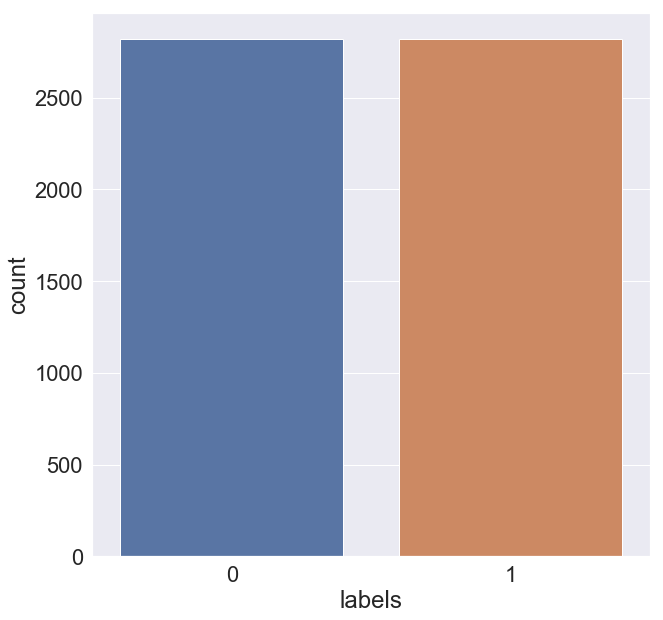

In [32]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [33]:
# Helper Functions  Learning Curves and Confusion Matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [34]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Old Class Weights:  [0.70422535 1.72413793]
New Class Weights:  [1. 1.]
